<a href="https://colab.research.google.com/github/AjmalMIITM/AjmalMIITM/blob/main/Token_Trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


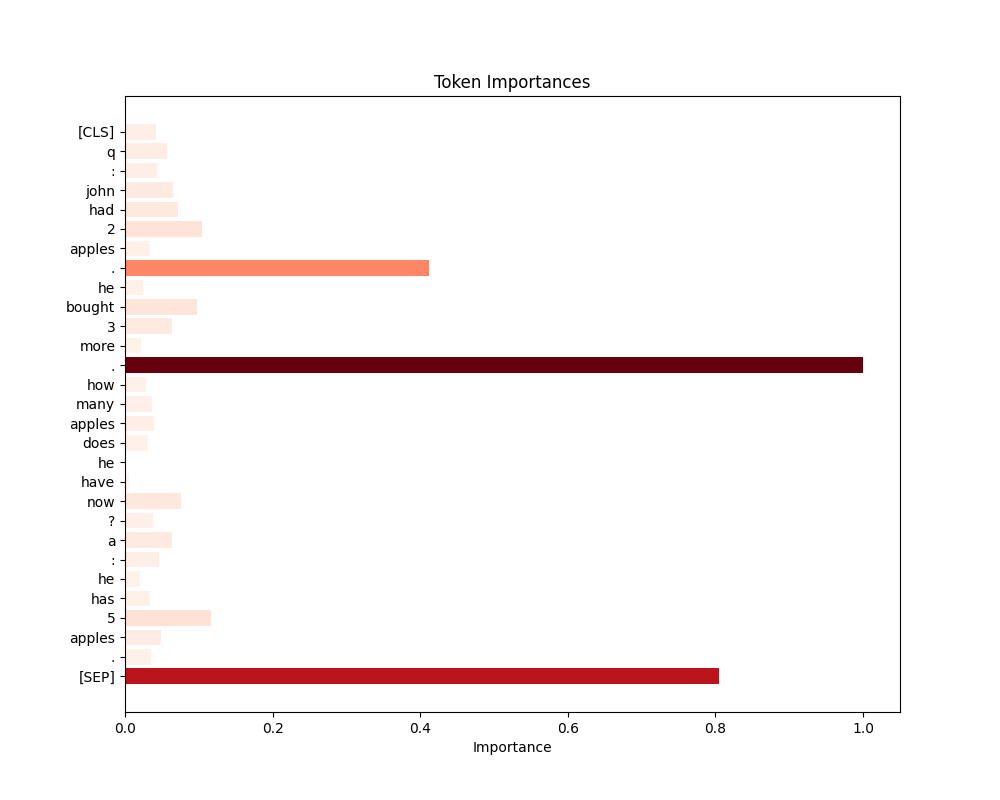

Files in the current directory:
token_importances.png


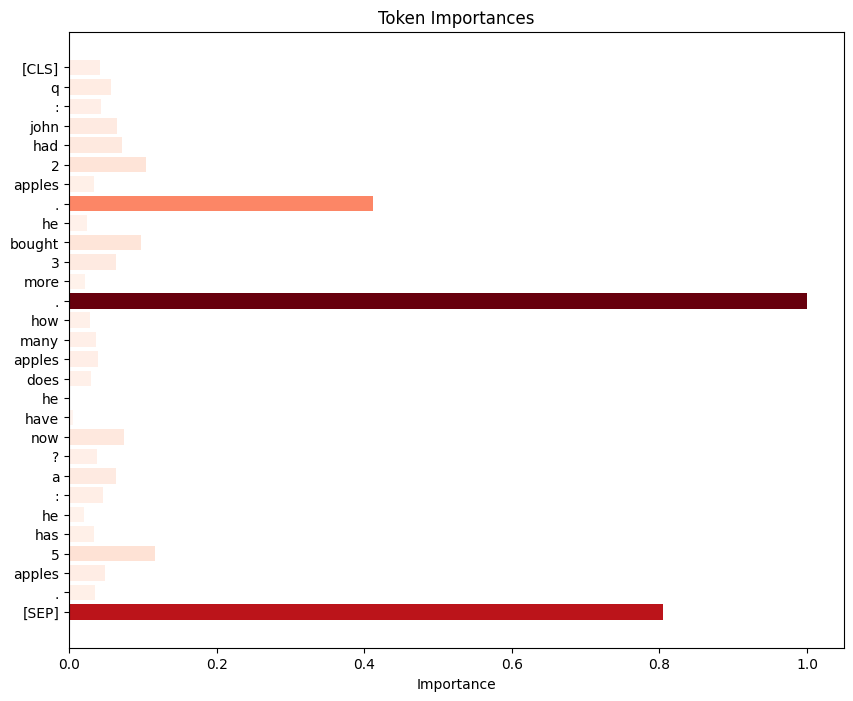

In [6]:
# Install necessary packages for transformers and visualization
!pip install -q transformers matplotlib

# Now start with the BERT-based attribution prototype
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from IPython.display import Image, display
import os

# Load model and tokenizer
model_name = "textattack/bert-base-uncased-SST-2"  # sentiment classification model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Input: Simple reasoning prompt
text = "Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples."
inputs = tokenizer(text, return_tensors="pt")
inputs.requires_grad = True  # for gradient tracking

# Forward pass
outputs = model(**inputs)
logits = outputs.logits
target_logit = logits[0, 1]  # Assuming positive sentiment (label 1)

# Backward pass
model.zero_grad()
target_logit.backward()

# Access attention weights from the last layer
attentions = outputs.attentions[-1]  # shape: [batch, heads, seq_len, seq_len]
attn_mean = attentions.mean(dim=1).squeeze(0)  # average across heads

# Compute gradients of input embeddings
grads = inputs["input_ids"].detach().clone().float()
token_importance = attn_mean.mean(dim=0).detach().numpy()

# Normalize importances for visualization
token_importance = (token_importance - np.min(token_importance)) / (np.max(token_importance) - np.min(token_importance))
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

# Visualization: Colored tokens
fig, ax = plt.subplots(figsize=(10, 8))
colors = cm.Reds(token_importance)

ax.barh(np.arange(len(tokens)), token_importance, color=colors)
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Token Importances')

# Save the plot to a file in the root directory
file_path = 'token_importances.png'
plt.savefig(file_path)

# Display the saved image
display(Image(filename=file_path))

# List files in the current directory to confirm the file exists
print("Files in the current directory:")
for file in os.listdir('.'):
    if os.path.isfile(file):
        print(file)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


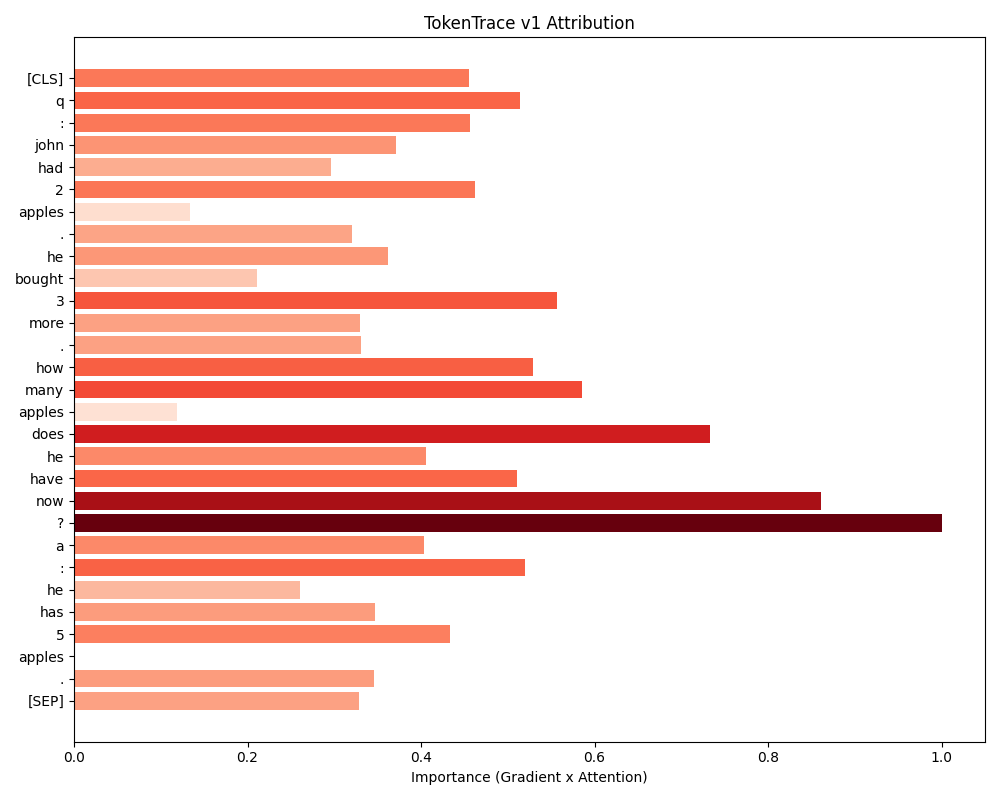

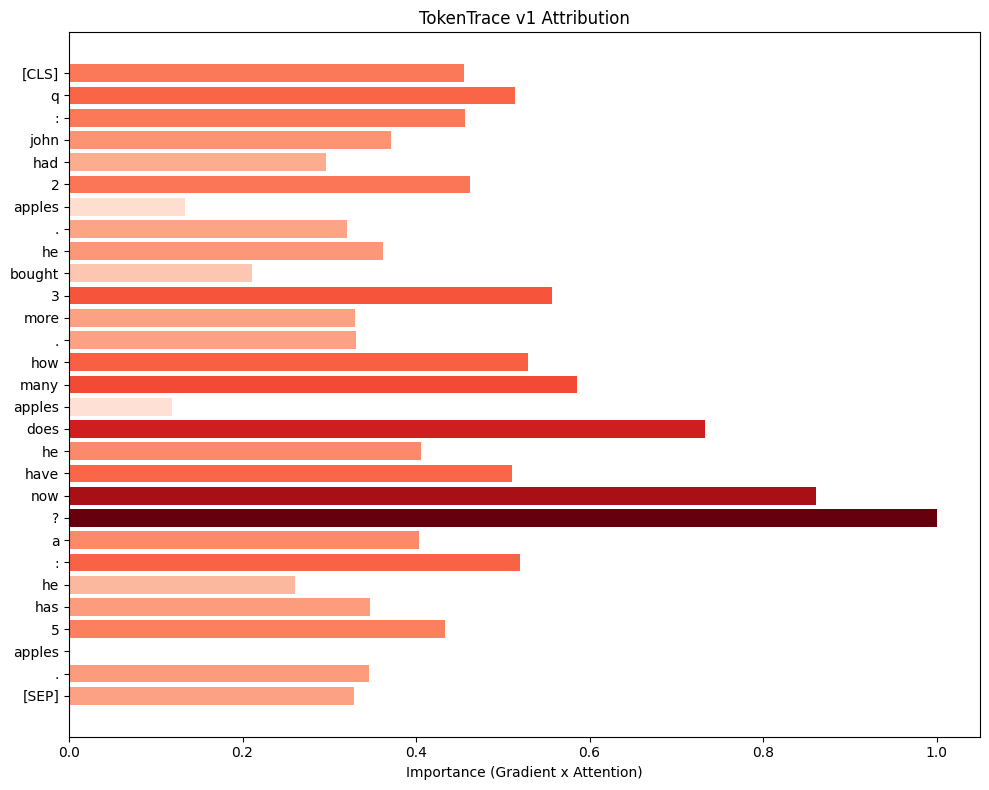

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import BertTokenizer, BertForSequenceClassification
import types
from IPython.display import Image, display

# Load pre-trained model
model_name = "textattack/bert-base-uncased-SST-2"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Input prompt
prompt = "Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples."
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

# --- TokenTrace v1 Implementation ---
# 1. Monkey-patch the forward method to get attention gradients
attention_gradients = None
def save_attention_grads_hook(grad):
    global attention_gradients
    attention_gradients = grad

def new_forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False, cache_position=None):
    mixed_query_layer = self.query(hidden_states)

    # If this is instantiated as a cross-attention module, the keys
    # and values come from an encoder; the attention mask needs to be
    # such that the encoder's padding tokens are not attended to.
    is_cross_attention = encoder_hidden_states is not None

    if is_cross_attention and past_key_value is not None:
        # reuse k,v, cross_attentions
        key_layer = past_key_value[0]
        value_layer = past_key_value[1]
        attention_mask = encoder_attention_mask
    elif is_cross_attention:
        key_layer = self.key(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        value_layer = self.value(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        attention_mask = encoder_attention_mask
    elif past_key_value is not None:
        key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
        value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
    else:
        key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

    query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

    # Take the dot product between "query" and "key" to get the raw attention scores.
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
        seq_length = hidden_states.size()[1]
        position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
        position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
        distance = position_ids_l - position_ids_r
        positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
        positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

        if self.position_embedding_type == "relative_key":
            relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores
        elif self.position_embedding_type == "relative_key_query":
            relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

    attention_scores = attention_scores / (self.attention_head_size**0.5)
    if attention_mask is not None:
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

    # Normalize the attention scores to probabilities.
    attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)

    # This is the important part: register the hook on the attention probabilities
    attention_probs.register_hook(save_attention_grads_hook)

    # This is actually dropping out entire tokens to attend to, which might
    # seem unusual, but is taken from the original Transformer paper.
    attention_probs = self.dropout(attention_probs)

    # Mask heads if we want to
    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    context_layer = context_layer.view(*new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

    if self.is_decoder:
        outputs = outputs + (past_key_value,)
    return outputs

model.bert.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.bert.encoder.layer[-1].attention.self)

# 2. Forward pass to get attention scores
outputs = model(**inputs)
attentions = outputs.attentions[-1]

# 3. Backward pass to get gradients
logits = outputs.logits
target_logit = logits[0, logits.argmax(dim=-1)] # Get the logit for the predicted class
target_logit.backward()

# 4. Calculate TokenTrace importance
grad_x_attn = attention_gradients * attentions
token_importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()


# Normalize importance
token_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())

# Convert token ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

# Plot as horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = cm.Reds(token_importance)

ax.barh(np.arange(len(tokens)), token_importance, color=colors)
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.invert_yaxis()
ax.set_xlabel('Importance (Gradient x Attention)')
ax.set_title('TokenTrace v1 Attribution')

plt.tight_layout()

# Save the plot to a file
plt.savefig('tokent_trace_plot.png')

# Display the saved image
display(Image(filename='tokent_trace_plot.png'))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


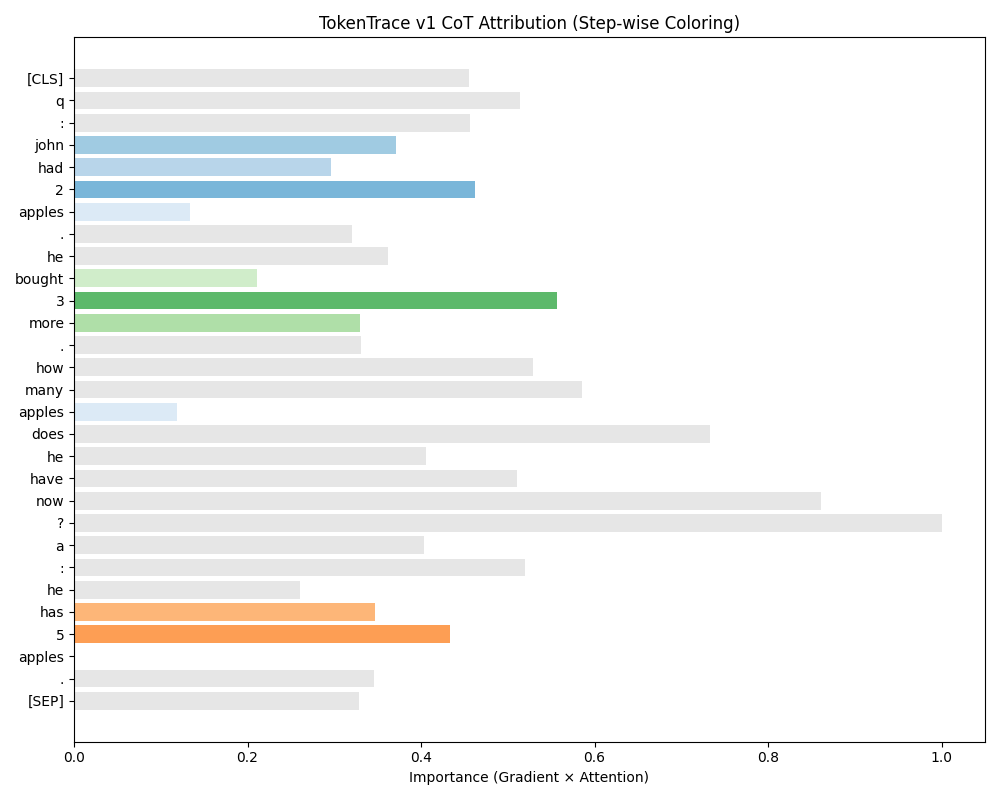

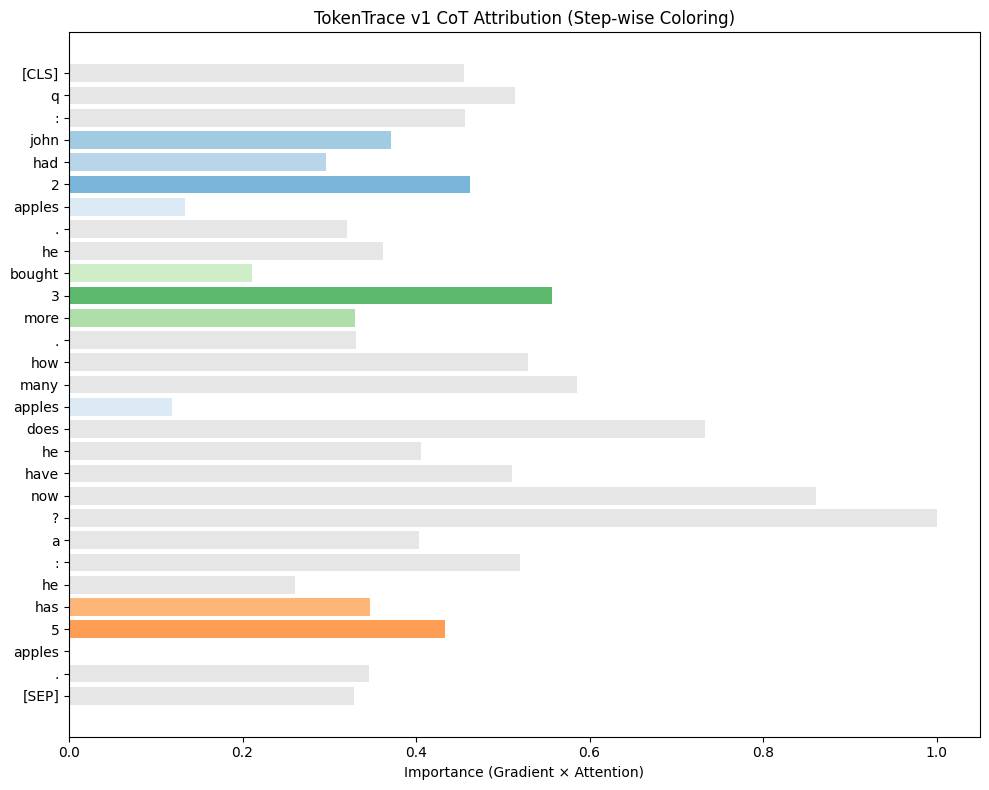

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import BertTokenizer, BertForSequenceClassification
import types
from IPython.display import Image, display

# Load model
model_name = "textattack/bert-base-uncased-SST-2"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Prompt (3-step CoT)
prompt = "Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples."
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]

# Hook for attention gradients
attention_gradients = None
def save_attention_grads_hook(grad):
    global attention_gradients
    attention_gradients = grad

# Monkey-patch last layer attention
def new_forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False, cache_position=None):
    query_layer = self.query(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
    key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
    value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) / (self.attention_head_size**0.5)
    if attention_mask is not None:
        attention_scores = attention_scores + attention_mask
    attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
    attention_probs.register_hook(save_attention_grads_hook)
    attention_probs = self.dropout(attention_probs)
    context_layer = torch.matmul(attention_probs, value_layer)
    context_layer = context_layer.permute(0, 2, 1, 3).contiguous().view(hidden_states.size(0), -1, self.all_head_size)
    return (context_layer, attention_probs) if output_attentions else (context_layer,)

model.bert.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.bert.encoder.layer[-1].attention.self)

# Forward & backward pass
outputs = model(**inputs)
attentions = outputs.attentions[-1]
logits = outputs.logits
target_logit = logits[0, logits.argmax(dim=-1)]
target_logit.backward()

# Compute Grad × Attention
grad_x_attn = attention_gradients * attentions
token_importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()
token_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

# Step-wise token indices (manual split)
step1_ids = ['john', 'had', '2', 'apples']
step2_ids = ['bought', '3', 'more']
step3_ids = ['has', '5', 'apples']
step_colors = []

# Assign color shades
for tok in tokens:
    t = tok.lower()
    if any(s in t for s in step1_ids):
        step_colors.append(cm.Blues(token_importance[tokens.index(tok)]))
    elif any(s in t for s in step2_ids):
        step_colors.append(cm.Greens(token_importance[tokens.index(tok)]))
    elif any(s in t for s in step3_ids):
        step_colors.append(cm.Oranges(token_importance[tokens.index(tok)]))
    else:
        step_colors.append((0.9, 0.9, 0.9, 1.0))  # light gray

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(np.arange(len(tokens)), token_importance, color=step_colors)
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.invert_yaxis()
ax.set_xlabel('Importance (Gradient × Attention)')
ax.set_title('TokenTrace v1 CoT Attribution (Step-wise Coloring)')
plt.tight_layout()
plt.savefig("stepwise_tokentrace.png")
display(Image(filename="stepwise_tokentrace.png"))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


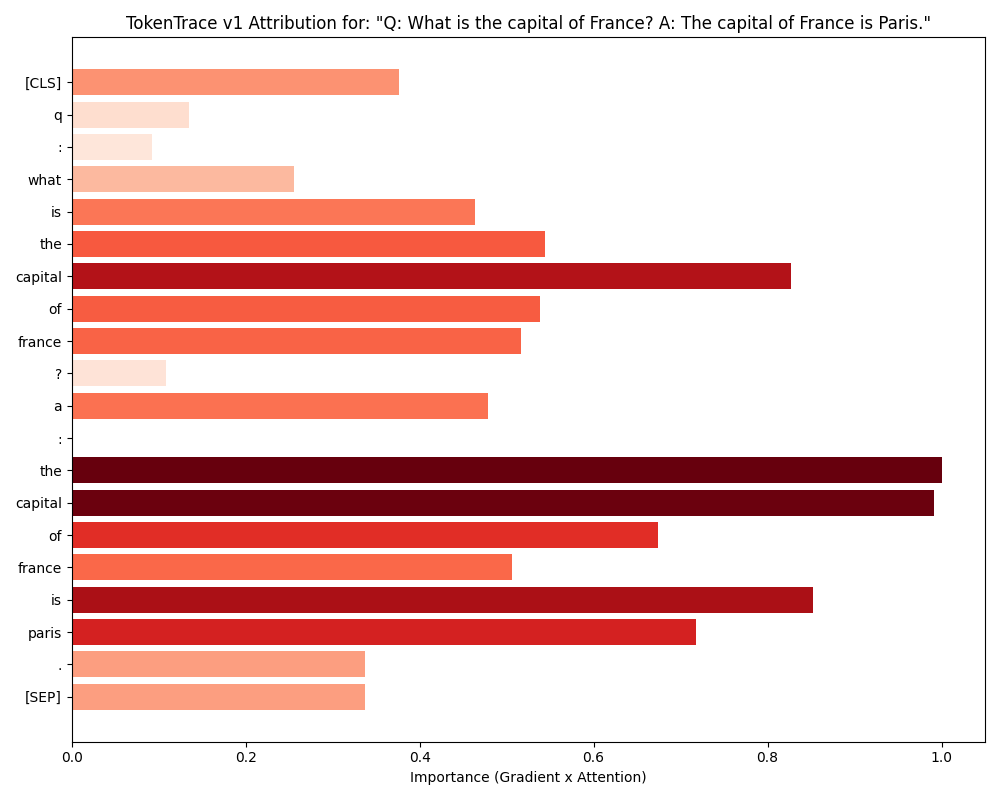

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


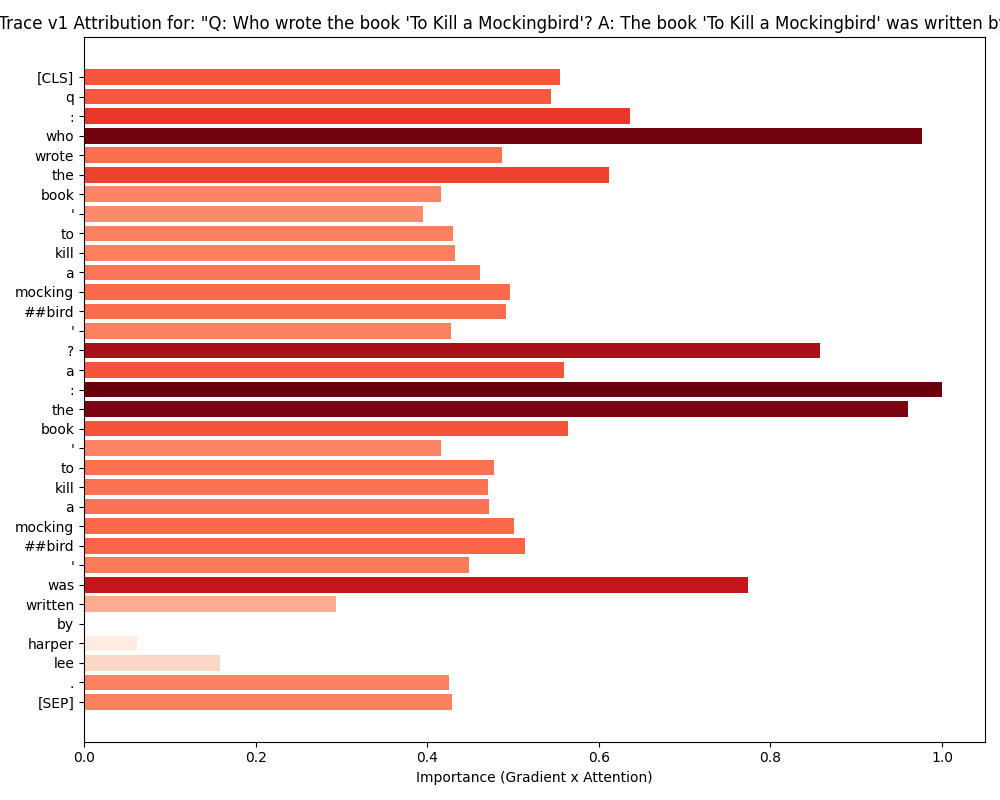

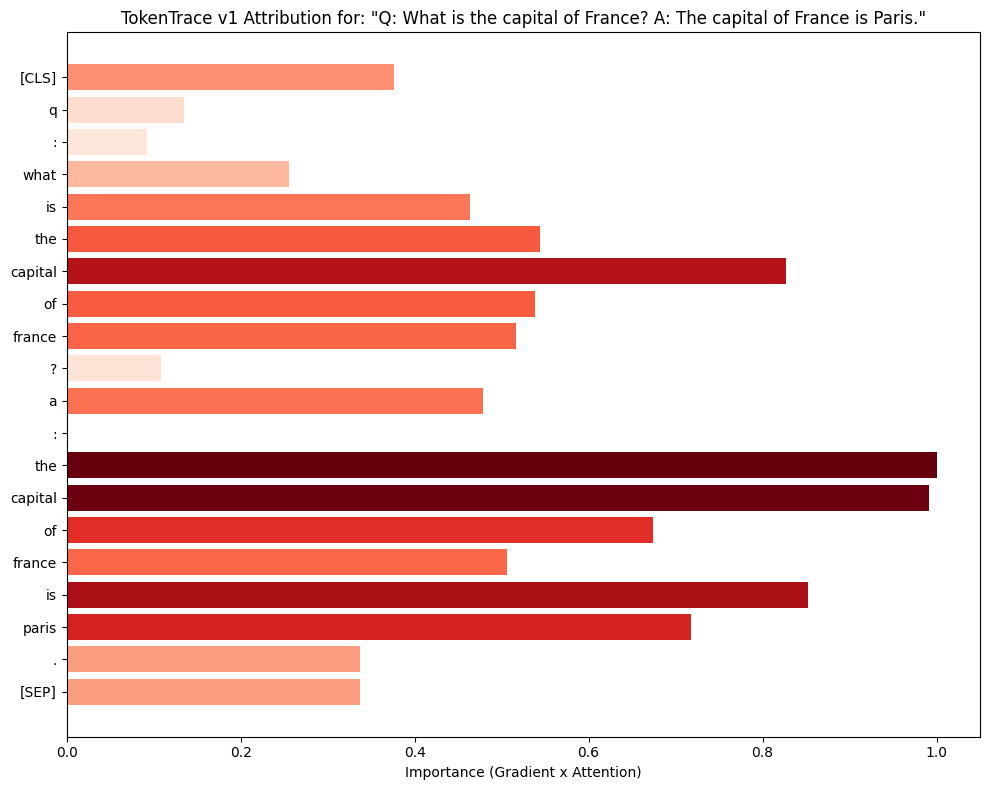

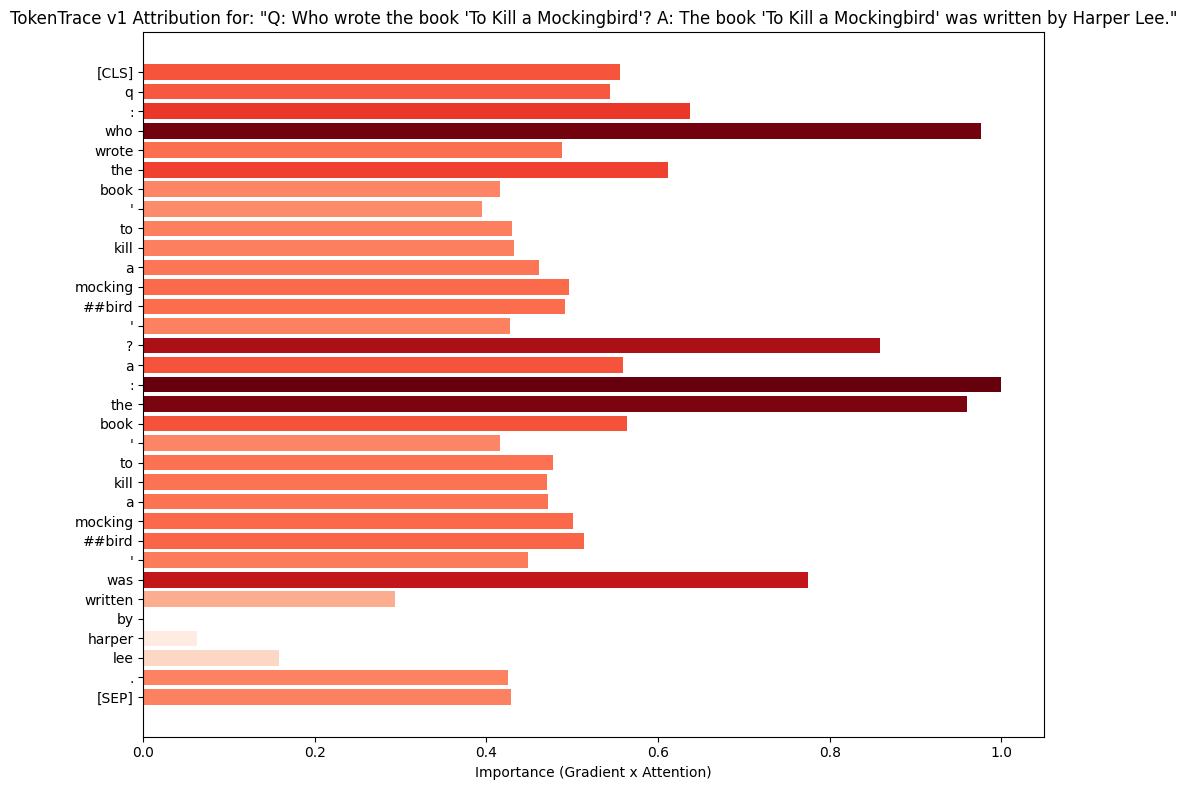

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import BertTokenizer, BertForSequenceClassification
import types
from IPython.display import Image, display

def run_tokentrace(prompt):
    # Load pre-trained model
    model_name = "textattack/bert-base-uncased-SST-2"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)
    model.eval()

    # Input prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # --- TokenTrace v1 Implementation ---
    # 1. Monkey-patch the forward method to get attention gradients
    attention_gradients = None
    def save_attention_grads_hook(grad):
        nonlocal attention_gradients
        attention_gradients = grad

    def new_forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False, cache_position=None):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.key(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / (self.attention_head_size**0.5)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)

        # This is the important part: register the hook on the attention probabilities
        attention_probs.register_hook(save_attention_grads_hook)

        # This is actually dropping out entire tokens to attend to, which might
        # seem unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask
        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

    model.bert.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.bert.encoder.layer[-1].attention.self)

    # 2. Forward pass to get attention scores
    outputs = model(**inputs)
    attentions = outputs.attentions[-1]

    # 3. Backward pass to get gradients
    logits = outputs.logits
    target_logit = logits[0, logits.argmax(dim=-1)] # Get the logit for the predicted class
    target_logit.backward()

    # 4. Calculate TokenTrace importance
    grad_x_attn = attention_gradients * attentions
    token_importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()


    # Normalize importance
    token_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())

    # Convert token ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Plot as horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = cm.Reds(token_importance)

    ax.barh(np.arange(len(tokens)), token_importance, color=colors)
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.invert_yaxis()
    ax.set_xlabel('Importance (Gradient x Attention)')
    ax.set_title(f'TokenTrace v1 Attribution for: "{prompt}"')

    plt.tight_layout()

    # Save the plot to a file
    filename = f'tokent_trace_{prompt[:20].replace(" ", "_")}.png'
    plt.savefig(filename)

    # Display the saved image
    display(Image(filename=filename))

# --- Run on new prompts ---
prompt1 = "Q: What is the capital of France? A: The capital of France is Paris."
prompt2 = "Q: Who wrote the book 'To Kill a Mockingbird'? A: The book 'To Kill a Mockingbird' was written by Harper Lee."

run_tokentrace(prompt1)
run_tokentrace(prompt2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


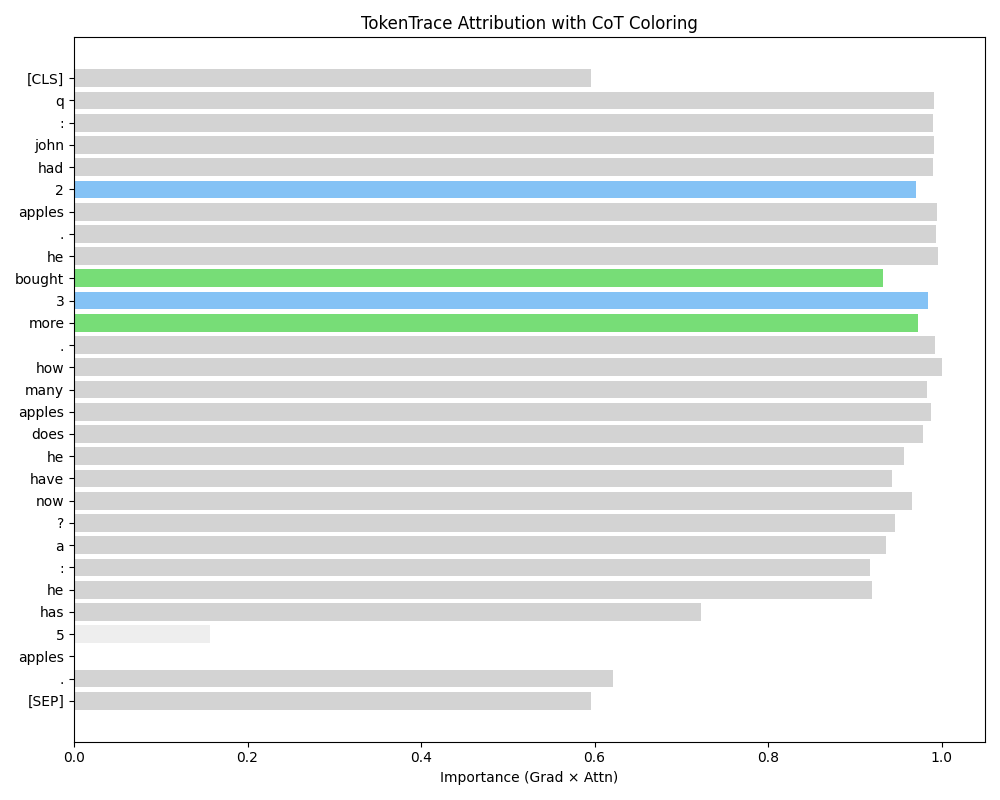

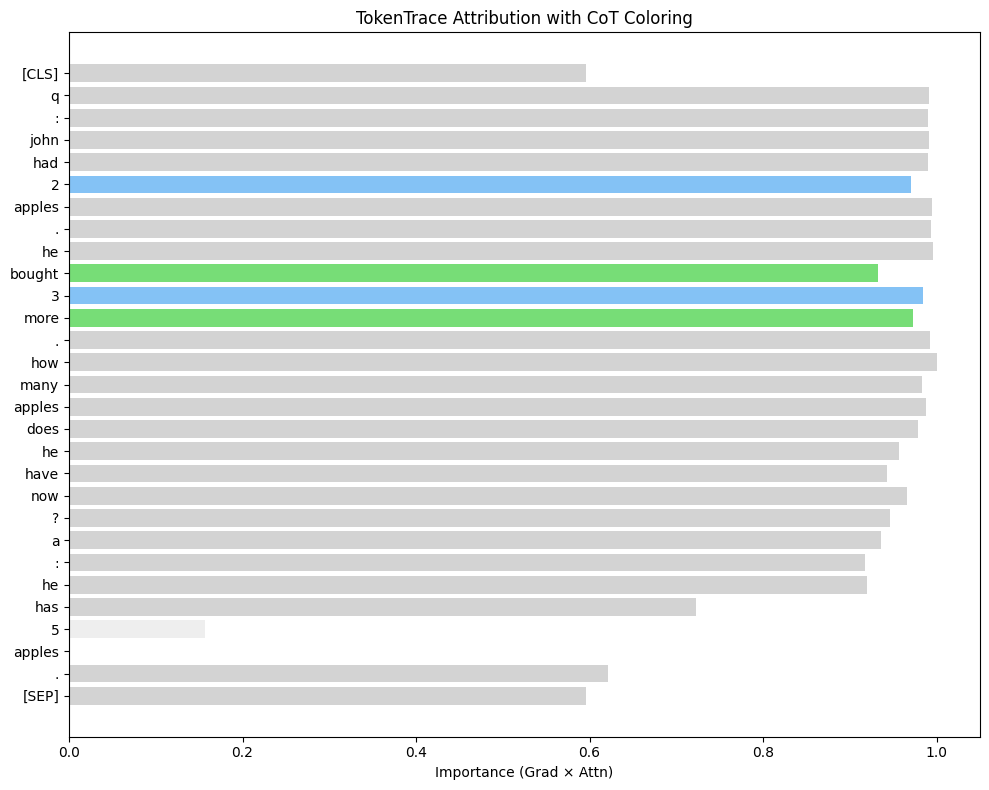

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import BertTokenizer, BertForQuestionAnswering
import types
import pandas as pd
from IPython.display import Image, display

def run_tokentrace(prompt, threshold=0.4):
    # Load QA-tuned BERT
    model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
    model.eval()

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    attention_gradients = None

    def save_attention_grads_hook(grad):
        nonlocal attention_gradients
        attention_gradients = grad

    # Monkey patch BERT to get grad * attention
    def new_forward(self, hidden_states, attention_mask=None, head_mask=None,
                    encoder_hidden_states=None, encoder_attention_mask=None,
                    past_key_value=None, output_attentions=False, cache_position=None):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.key(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        elif past_key_value is not None:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs.register_hook(save_attention_grads_hook)
        attention_probs = self.dropout(attention_probs)

        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        context_layer = context_layer.view(context_layer.size(0), -1, self.all_head_size)
        return (context_layer, attention_probs) if output_attentions else (context_layer,)

    model.bert.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.bert.encoder.layer[-1].attention.self)

    outputs = model(**inputs)
    attentions = outputs.attentions[-1]
    start_logits = outputs.start_logits
    target_logit = start_logits[0].max()
    model.zero_grad()
    target_logit.backward()

    grad_x_attn = attention_gradients * attentions
    token_importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()
    token_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())

    # Label steps
    step_labels = []
    for tok in tokens:
        if tok.isdigit():
            step_labels.append("number")
        elif tok in ["more", "plus", "added", "bought"]:
            step_labels.append("operation")
        elif tok in ["5", "seven", "nine", "six"]:
            step_labels.append("final_answer")
        else:
            step_labels.append("other")

    # Save .csv
    df = pd.DataFrame({"token": tokens, "importance": token_importance, "step": step_labels})
    df.to_csv("tokentrace_output.csv", index=False)

    # Visualize with color per step
    color_map = {
        "number": "#84c2f5",       # blue
        "operation": "#77dd77",    # green
        "final_answer": "#ffb347", # orange
        "other": "#d3d3d3",        # light gray
    }
    colors = [color_map[label] if score > threshold else "#eeeeee" for score, label in zip(token_importance, step_labels)]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(np.arange(len(tokens)), token_importance, color=colors)
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.invert_yaxis()
    ax.set_xlabel("Importance (Grad × Attn)")
    ax.set_title("TokenTrace Attribution with CoT Coloring")

    plt.tight_layout()
    plt.savefig("tokentrace_cot.png")
    display(Image(filename="tokentrace_cot.png"))

# Run it
prompt = "Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples."
run_tokentrace(prompt)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


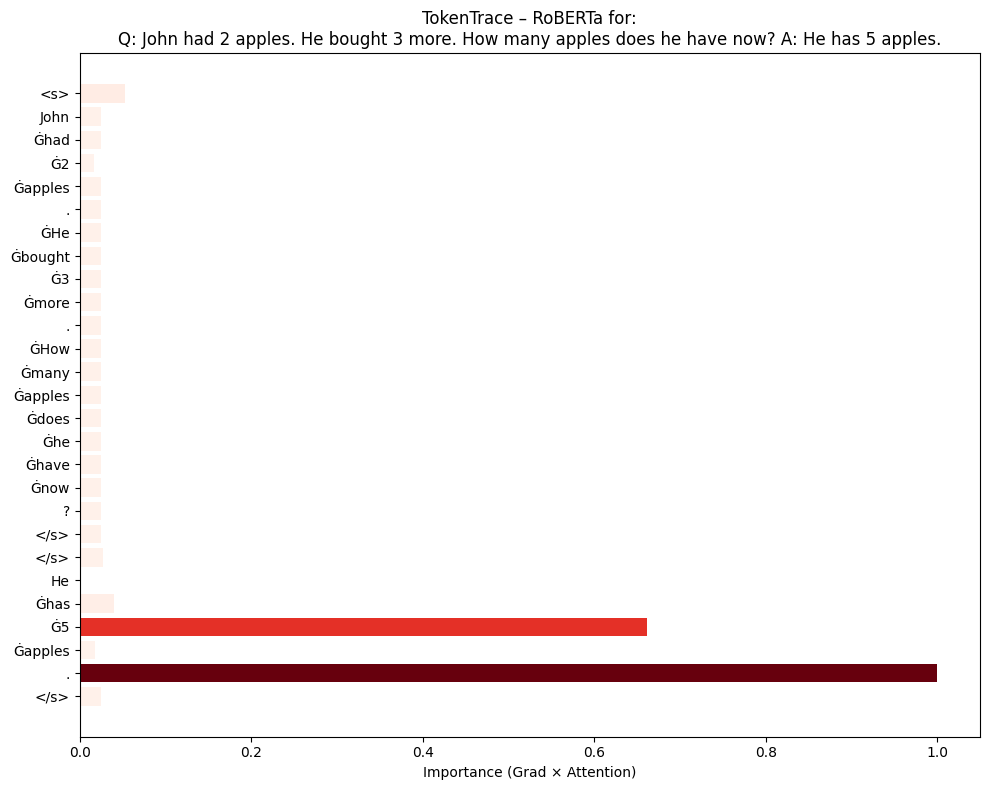

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import types
import csv

def run_roberta_tokentrace(prompt):
    # Load model + tokenizer
    model_name = "deepset/roberta-base-squad2"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
    model.eval()

    # Split prompt into question and context
    q_prefix = "Q:"
    a_prefix = "A:"
    if q_prefix in prompt and a_prefix in prompt:
        question = prompt.split(q_prefix)[1].split(a_prefix)[0].strip()
        context = prompt.split(a_prefix)[1].strip()
    else:
        raise ValueError("Prompt format should be 'Q: ... A: ...'")

    # Tokenize
    inputs = tokenizer(question, context, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Hook for attention gradients
    attention_grads = None
    def save_attention_grads_hook(grad):
        nonlocal attention_grads
        attention_grads = grad

    # Patch self-attention forward pass
    def new_forward(self, hidden_states, attention_mask=None, head_mask=None,
                    encoder_hidden_states=None, encoder_attention_mask=None,
                    past_key_value=None, output_attentions=False, cache_position=None):
        mixed_query_layer = self.query(hidden_states)
        key_layer = self.key(hidden_states)
        value_layer = self.value(hidden_states)

        query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        key_layer = key_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        value_layer = value_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores += attention_mask

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)

        # Register gradient hook
        attention_probs.register_hook(save_attention_grads_hook)

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_shape)
        return (context_layer, attention_probs) if output_attentions else (context_layer,)

    # Monkey-patch last layer
    model.roberta.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.roberta.encoder.layer[-1].attention.self)

    # Forward pass
    outputs = model(**inputs)
    attentions = outputs.attentions[-1]  # Last layer attention
    start_logits, end_logits = outputs.start_logits, outputs.end_logits

    # Get predicted start or end position
    target_logit = start_logits[0].max() + end_logits[0].max()
    model.zero_grad()
    target_logit.backward()

    # Compute grad × attention
    grad_x_attn = attention_grads * attentions  # [B, H, T, T]
    importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()

    # Normalize
    importance = (importance - importance.min()) / (importance.max() - importance.min())
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = cm.Reds(importance)
    ax.barh(np.arange(len(tokens)), importance, color=colors)
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.invert_yaxis()
    ax.set_xlabel('Importance (Grad × Attention)')
    ax.set_title(f'TokenTrace – RoBERTa for:\n{prompt}')
    plt.tight_layout()
    plt.show()

    # Export to CSV
    with open("roberta_tokentrace.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Token", "Importance"])
        for token, score in zip(tokens, importance):
            writer.writerow([token, score])

# 🔁 Run on your earlier prompts
run_roberta_tokentrace("Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

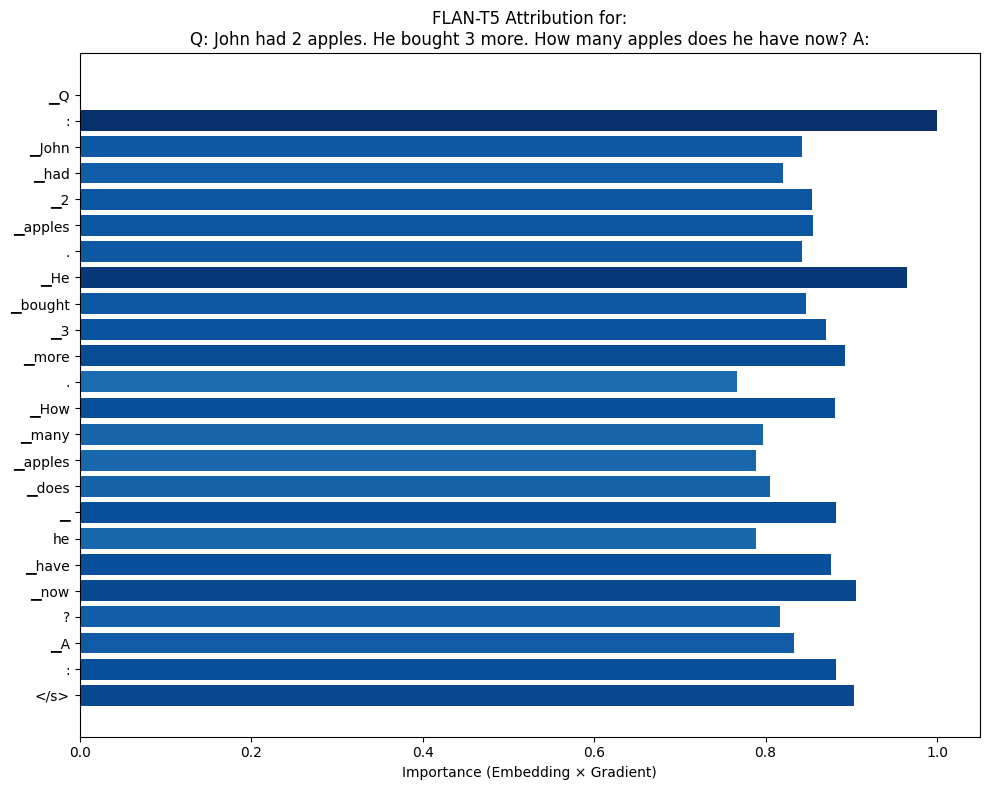

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import csv

def run_flan_tokentrace(prompt):
    model_name = "google/flan-t5-base"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    model.eval()

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Get embeddings and set requires_grad
    embeddings = model.encoder.embed_tokens(input_ids)
    embeddings.retain_grad()
    embeddings.requires_grad_()

    # Forward pass using embeddings
    encoder_outputs = model.encoder(inputs_embeds=embeddings)
    decoder_input_ids = tokenizer("He has", return_tensors="pt").input_ids  # Seed
    outputs = model(
        encoder_outputs=encoder_outputs,
        decoder_input_ids=decoder_input_ids,
        return_dict=True
    )

    # Pick logit of first token generated ("He") as target
    target_logit = outputs.logits[0, 0].max()
    model.zero_grad()
    target_logit.backward()

    # Compute Input × Gradient
    grads = embeddings.grad
    saliency = (embeddings * grads).sum(dim=-1).squeeze().detach().numpy()

    # Normalize
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = cm.Blues(saliency)
    ax.barh(np.arange(len(tokens)), saliency, color=colors)
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_yticklabels(tokens)
    ax.invert_yaxis()
    ax.set_xlabel('Importance (Embedding × Gradient)')
    ax.set_title(f'FLAN-T5 Attribution for:\n{prompt}')
    plt.tight_layout()
    plt.show()

    # Save to CSV
    with open("flan_tokentrace.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Token", "Importance"])
        for token, score in zip(tokens, saliency):
            writer.writerow([token, score])

# 🔁 Run on earlier prompt
run_flan_tokentrace("Q: John had 2 apples. He bought 3 more. How many apples does he have now? A:")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: 

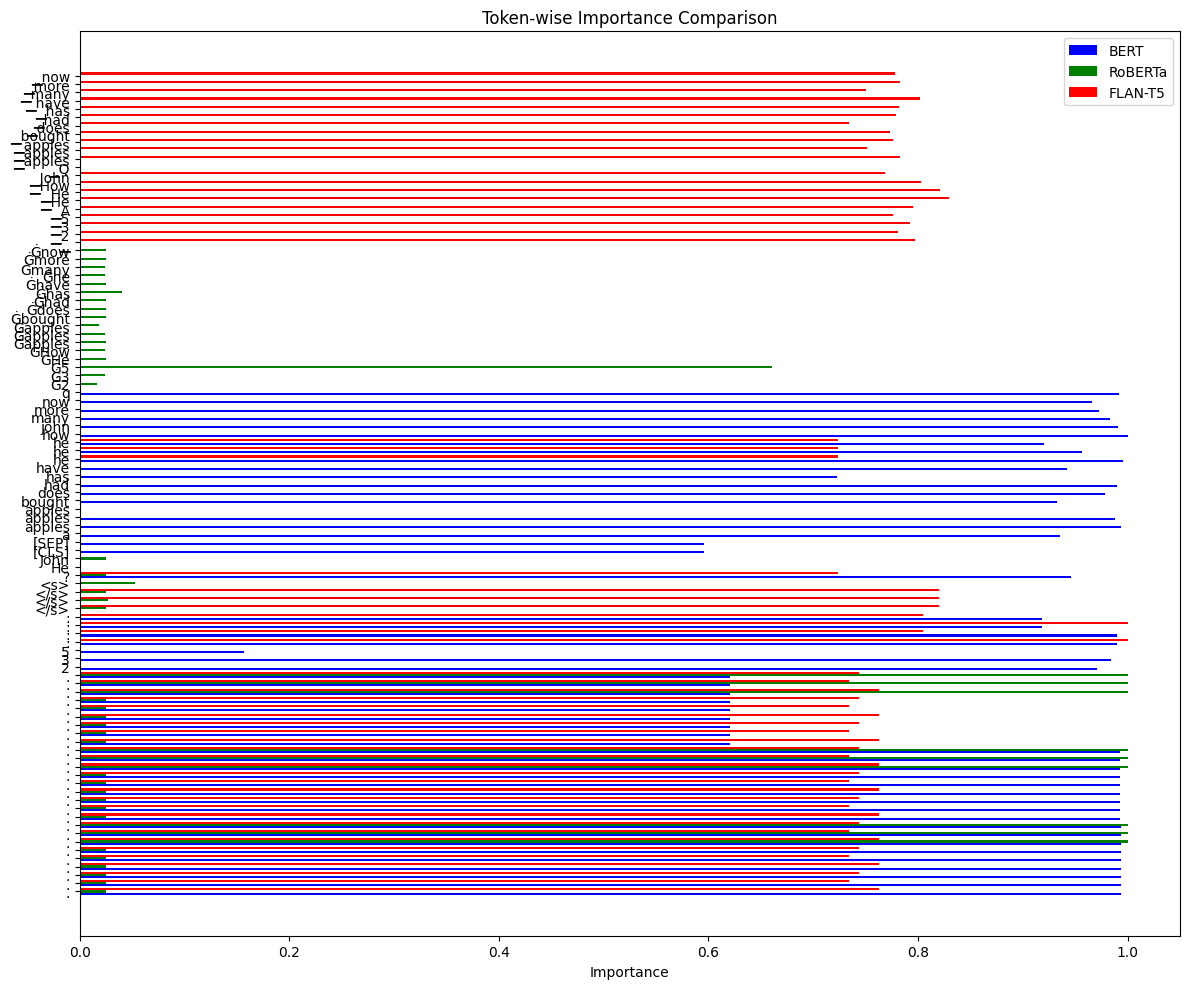

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import BertTokenizer, BertForQuestionAnswering, RobertaTokenizer, RobertaForQuestionAnswering, T5Tokenizer, T5ForConditionalGeneration
import types
import pandas as pd
from IPython.display import Image, display

def run_bert_tokentrace(prompt):
    # Load QA-tuned BERT
    model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
    model.eval()

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    attention_gradients = None

    def save_attention_grads_hook(grad):
        nonlocal attention_gradients
        attention_gradients = grad

    # Monkey patch BERT to get grad * attention
    def new_forward(self, hidden_states, attention_mask=None, head_mask=None,
                    encoder_hidden_states=None, encoder_attention_mask=None,
                    past_key_value=None, output_attentions=False, cache_position=None):
        mixed_query_layer = self.query(hidden_states)
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.key(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(encoder_hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        elif past_key_value is not None:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.key(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
            value_layer = self.value(hidden_states).view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs.register_hook(save_attention_grads_hook)
        attention_probs = self.dropout(attention_probs)

        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        context_layer = context_layer.view(context_layer.size(0), -1, self.all_head_size)
        return (context_layer, attention_probs) if output_attentions else (context_layer,)

    model.bert.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.bert.encoder.layer[-1].attention.self)

    outputs = model(**inputs)
    attentions = outputs.attentions[-1]
    start_logits = outputs.start_logits
    target_logit = start_logits[0].max()
    model.zero_grad()
    target_logit.backward()

    grad_x_attn = attention_gradients * attentions
    token_importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()
    token_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())

    return tokens, token_importance

def run_roberta_tokentrace(prompt):
    # Load model + tokenizer
    model_name = "deepset/roberta-base-squad2"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
    model.eval()

    # Split prompt into question and context
    q_prefix = "Q:"
    a_prefix = "A:"
    if q_prefix in prompt and a_prefix in prompt:
        question = prompt.split(q_prefix)[1].split(a_prefix)[0].strip()
        context = prompt.split(a_prefix)[1].strip()
    else:
        raise ValueError("Prompt format should be 'Q: ... A: ...'")

    # Tokenize
    inputs = tokenizer(question, context, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Hook for attention gradients
    attention_grads = None
    def save_attention_grads_hook(grad):
        nonlocal attention_grads
        attention_grads = grad

    # Patch self-attention forward pass
    def new_forward(self, hidden_states, attention_mask=None, head_mask=None,
                    encoder_hidden_states=None, encoder_attention_mask=None,
                    past_key_value=None, output_attentions=False, cache_position=None):
        mixed_query_layer = self.query(hidden_states)
        key_layer = self.key(hidden_states)
        value_layer = self.value(hidden_states)

        query_layer = mixed_query_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        key_layer = key_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)
        value_layer = value_layer.view(hidden_states.size(0), -1, self.num_attention_heads, self.attention_head_size).permute(0, 2, 1, 3)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores += attention_mask

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)

        # Register gradient hook
        attention_probs.register_hook(save_attention_grads_hook)

        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_shape)
        return (context_layer, attention_probs) if output_attentions else (context_layer,)

    # Monkey-patch last layer
    model.roberta.encoder.layer[-1].attention.self.forward = types.MethodType(new_forward, model.roberta.encoder.layer[-1].attention.self)

    # Forward pass
    outputs = model(**inputs)
    attentions = outputs.attentions[-1]  # Last layer attention
    start_logits, end_logits = outputs.start_logits, outputs.end_logits

    # Get predicted start or end position
    target_logit = start_logits[0].max() + end_logits[0].max()
    model.zero_grad()
    target_logit.backward()

    # Compute grad × attention
    grad_x_attn = attention_grads * attentions  # [B, H, T, T]
    importance = grad_x_attn.sum(dim=(1, 2)).squeeze(0).detach().numpy()

    # Normalize
    importance = (importance - importance.min()) / (importance.max() - importance.min())

    return tokens, importance

def run_flan_tokentrace(prompt):
    model_name = "google/flan-t5-base"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    model.eval()

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Get embeddings and set requires_grad
    embeddings = model.encoder.embed_tokens(input_ids)
    embeddings.retain_grad()
    embeddings.requires_grad_()

    # Forward pass using embeddings
    encoder_outputs = model.encoder(inputs_embeds=embeddings)
    decoder_input_ids = tokenizer("He has", return_tensors="pt").input_ids  # Seed
    outputs = model(
        encoder_outputs=encoder_outputs,
        decoder_input_ids=decoder_input_ids,
        return_dict=True
    )

    # Pick logit of first token generated ("He") as target
    target_logit = outputs.logits[0, 0].max()
    model.zero_grad()
    target_logit.backward()

    # Compute Input × Gradient
    grads = embeddings.grad
    saliency = (embeddings * grads).sum(dim=-1).squeeze().detach().numpy()

    # Normalize
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    return tokens, saliency

# Run on the same prompt
prompt = "Q: John had 2 apples. He bought 3 more. How many apples does he have now? A: He has 5 apples."
bert_tokens, bert_importance = run_bert_tokentrace(prompt)
roberta_tokens, roberta_importance = run_roberta_tokentrace(prompt)
flan_tokens, flan_importance = run_flan_tokentrace(prompt)

# Create a combined dataframe
df = pd.DataFrame({
    'token': bert_tokens,
    'bert_importance': bert_importance,
})
roberta_df = pd.DataFrame({
    'token': roberta_tokens,
    'roberta_importance': roberta_importance
})
flan_df = pd.DataFrame({
    'token': flan_tokens,
    'flan_importance': flan_importance
})

# Merge dataframes
df = df.merge(roberta_df, on='token', how='outer')
df = df.merge(flan_df, on='token', how='outer')
df = df.fillna(0)

# Save to CSV
df.to_csv("combined_tokentrace.csv", index=False)

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.25
index = np.arange(len(df['token']))

bar1 = ax.barh(index, df['bert_importance'], bar_width, label='BERT', color='b')
bar2 = ax.barh(index + bar_width, df['roberta_importance'], bar_width, label='RoBERTa', color='g')
bar3 = ax.barh(index + 2 * bar_width, df['flan_importance'], bar_width, label='FLAN-T5', color='r')

ax.set_xlabel('Importance')
ax.set_title('Token-wise Importance Comparison')
ax.set_yticks(index + bar_width)
ax.set_yticklabels(df['token'])
ax.legend()

plt.tight_layout()
plt.show()